In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, 
    recall_score, f1_score, matthews_corrcoef
)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# --- 1. DATA PREPROCESSING ---
df = pd.read_csv('default of credit card clients.csv', header=1)

# Requirement: Drop ID column (it's non-predictive)
if 'ID' in df.columns:
    df = df.drop(columns=['ID'])

In [3]:
# Split Features (X) and Target (Y)
# X is X1-X23, Y is 'default payment next month'
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# Scaling 
os.makedirs('model', exist_ok=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'model/scaler.pkl')

['model/scaler.pkl']

In [5]:
# --- 2. MODEL IMPLEMENTATION ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(max_depth=10),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)}

results = []

for name, model in models.items():
    # Use scaled data for distance-based models, raw for tree-based
    if name in ["Logistic Regression", "KNN", "Naive Bayes"]:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Train
    model.fit(X_tr, y_train)
    
    # Predict
    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else y_pred
    
    # Calculate the 6 Required Metrics
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC Score": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "MCC Score": matthews_corrcoef(y_test, y_pred)
    }
    results.append(metrics)
    
    # Save Model for Streamlit
    file_name = name.lower().replace(" ", "_") + ".pkl"
    joblib.dump(model, f'model/{file_name}')
    print(f"{name} trained and saved as {file_name}")

Logistic Regression trained and saved as logistic_regression.pkl
Decision Tree trained and saved as decision_tree.pkl
KNN trained and saved as knn.pkl
Naive Bayes trained and saved as naive_bayes.pkl
Random Forest trained and saved as random_forest.pkl
XGBoost trained and saved as xgboost.pkl


In [6]:
# --- 3. RESULTS COMPARISON ---
performance_df = pd.DataFrame(results)
print("\n--- Model Performance Comparison ---")
print(performance_df.to_string(index=False))

# Export for Streamlit to display
performance_df.to_csv('model_metrics.csv', index=False)


--- Model Performance Comparison ---
              Model  Accuracy  AUC Score  Precision   Recall  F1 Score  MCC Score
Logistic Regression  0.807667   0.707636   0.686825 0.239638  0.355307   0.324443
      Decision Tree  0.809667   0.718170   0.622193 0.354936  0.452015   0.367154
                KNN  0.792833   0.701435   0.548724 0.356443  0.432161   0.323267
        Naive Bayes  0.752500   0.724930   0.451474 0.553881  0.497462   0.338620
      Random Forest  0.813333   0.751038   0.636005 0.364732  0.463602   0.380948
            XGBoost  0.811833   0.756469   0.628906 0.363979  0.461098   0.376398


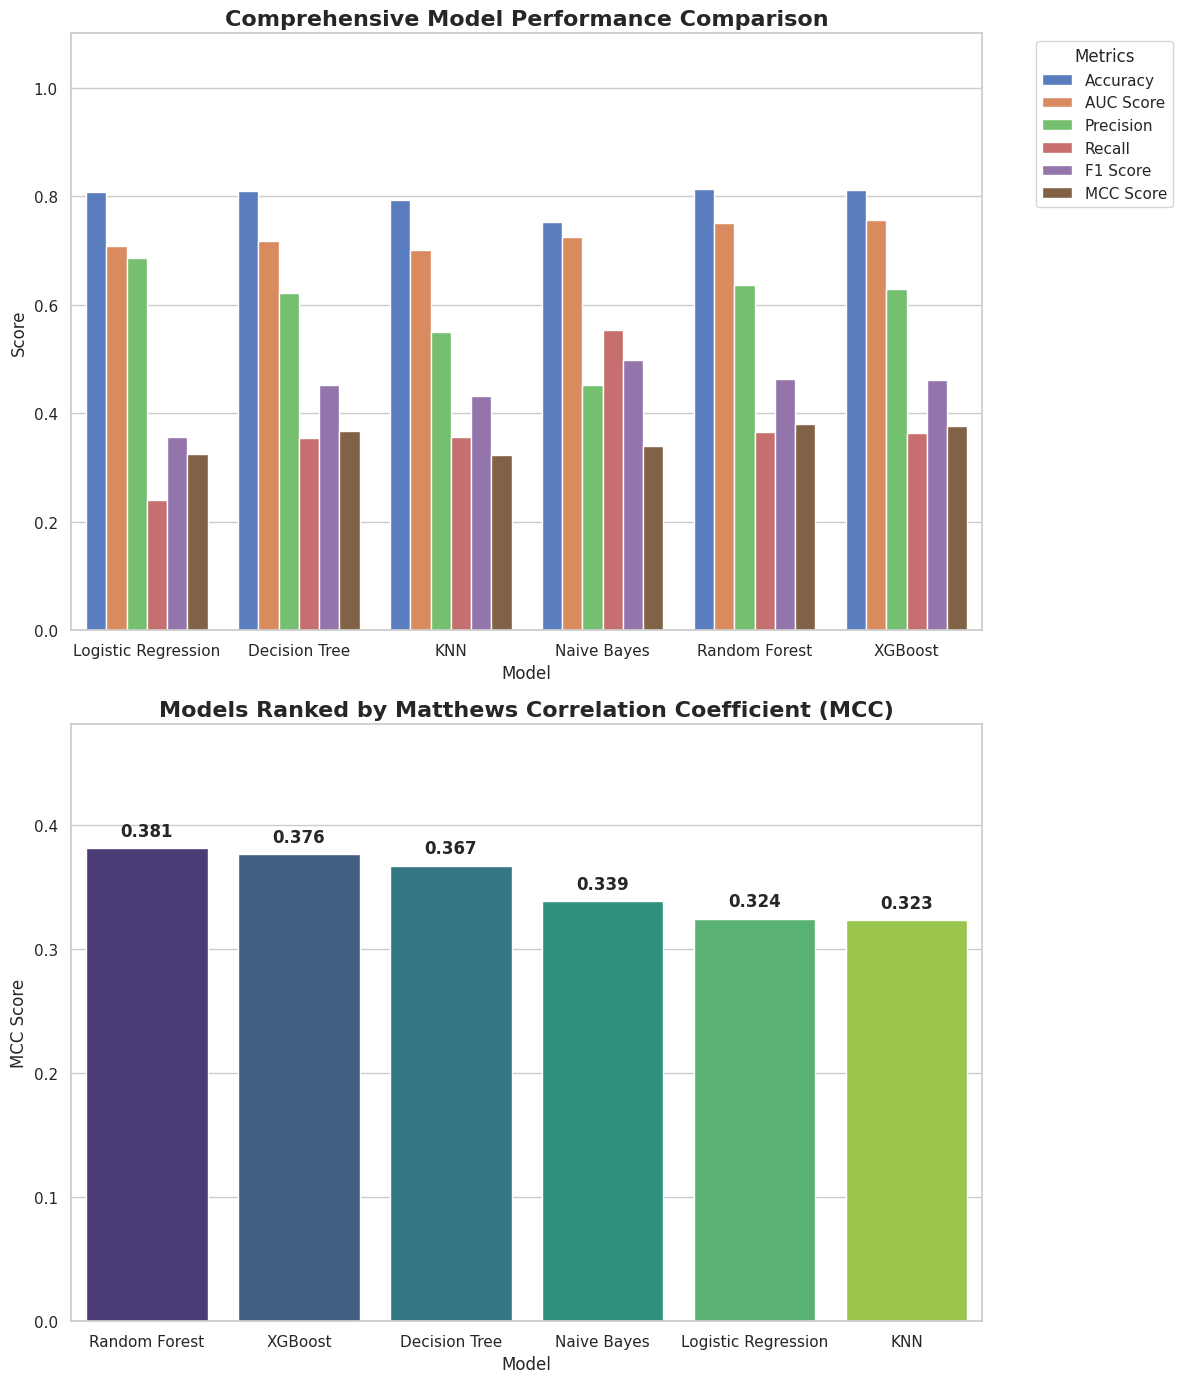

In [7]:
sns.set_theme(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# Visualization A: Grouped Bar Chart for all metrics
df_melted = performance_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

sns.barplot(data=df_melted, x='Model', y='Score', hue='Metric', ax=ax1, palette='muted')
ax1.set_title('Comprehensive Model Performance Comparison', fontsize=16, fontweight='bold')
ax1.set_ylim(0, 1.1) 
ax1.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

# Visualization B: Ranking by MCC Score (The "Honest" Metric)
df_sorted_mcc = performance_df.sort_values('MCC Score', ascending=False)
sns.barplot(data=df_sorted_mcc, x='Model', y='MCC Score', hue='Model', palette='viridis', ax=ax2, legend=False)
ax2.set_title('Models Ranked by Matthews Correlation Coefficient (MCC)', fontsize=16, fontweight='bold')
ax2.set_ylim(0, df_sorted_mcc['MCC Score'].max() + 0.1)

for i, v in enumerate(df_sorted_mcc['MCC Score']):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

fig.savefig('model/comparison_plot.png')